# Imports

In [1]:
import webdriver_manager
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from webdriver_manager.firefox import GeckoDriverManager
from selenium.webdriver.chrome.service import Service as ChromeService
from IPython.display import clear_output
import time
import pandas as pd
import IPython
import os

# Driver and Functions

In [2]:
driver = webdriver.Chrome(service=ChromeService(ChromeDriverManager().install()))

In [3]:
def login():
    driver.get("https://ocs.iitd.ac.in/portal/login")
    ID = "phs217181"
    password = input("Enter your password: ")
    driver.get("https://ocs.iitd.ac.in/portal/login")
    driver.find_element(By.ID, "mat-input-0").send_keys(ID)
    driver.find_element(By.ID, "mat-input-1").send_keys(password)
    captcha = driver.find_element(By.TAG_NAME, "object")
    captcha.screenshot("captcha.png")
    IPython.display.display(IPython.display.Image("captcha.png"))
    captcha_code = input("Enter the captcha code: ")
    driver.find_element(By.ID, "mat-input-2").send_keys(captcha_code)
    driver.find_element(By.TAG_NAME, "button").click()

In [4]:
def list_companies(url = "https://ocs.iitd.ac.in/portal/student/applications", class1= "mat-select-value-5", class2 = "mat-option-14"):
    driver.get(url)
    driver.find_element(By.ID, class1).click()
    driver.find_element(By.ID, class2).click()
    max_rows = int(driver.find_element(By.CLASS_NAME, "mat-paginator-range-label").text.split(" ")[-1])
    return max_rows

In [5]:
def result(max_rows):
    companies = []
    profiles = []
    page_num = 0
    per_page = 50
    while page_num*per_page<=max_rows:
        print(f"Currently on page {page_num+1}", end="\r")
        table = driver.find_element(By.TAG_NAME, "table")
        rows = table.find_elements(By.TAG_NAME, "tr")
        for i in range(1, len(rows)):
            data = rows[i].find_element(By.TAG_NAME, "td").text.split("\n")[0]
            company = data.split("(")[0]
            profile = data.split("(")[1].split(")")[0]
            companies.append(company.strip())
            profiles.append(profile.strip())
        next_btn = driver.find_elements(By.CLASS_NAME, "mat-button-wrapper")[1]
        next_btn.click()
        page_num+=1
    all_companies = pd.DataFrame([companies, profiles]).T
    all_companies.columns = ["Company", "Profile"]
    return all_companies

In [6]:
def logout():
    for item in driver.find_elements(By.TAG_NAME ,"mat-icon"):
        if item.text == "exit_to_app":
            item.click()
            return None

# Start

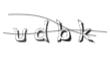

In [7]:
login()
os.remove("captcha.png")

## MSC List

In [8]:
max_rows = list_companies()
msc_df = result(max_rows=max_rows)

In [9]:
msc_df

,Company,Profile
0,Javis,Software Development Engineer I
1,Javis,Data Engineer I
2,Javis,Machine Learning Engineer I
3,Javis,Software Development Engineer I
4,Truminds Software Systems,Software Development Engineer
...,...,...
97,Sony Group Corporation,JAF11 : Software testing engineer
98,Sony Group Corporation,JAF12 : Image Sensor device/pixel Research&Dev...
99,Piramal,Management Trainee - Business Intelligence Unit
100,DMI Finance,AM - Analytics


## All List

In [ ]:
# url = "https://ocs.iitd.ac.in/portal/student/companies"
# class1= "mat-select-value-3"
# class2 = "mat-option-10"
# max_rows = list_companies(url = url, class1=class1, class2=class2)
# all_df = result(max_rows=max_rows)

In [10]:
# all_df

In [11]:
logout()

In [12]:
driver.close()

# Analysis

## Loading the Older List

In [13]:
msc_old = pd.read_csv("msc.csv")
# all_old = pd.read_csv("all.csv")

## Comparing

In [14]:
if len(msc_old)!=len(msc_df):
    print("Some things have changed!")
    changed = True
else:
    print("Everything is the Same.")
    changed = False

Some things have changed!


In [15]:
if changed:
    diff = len(msc_old)-len(msc_df)
    if diff<0:
        print(f"A total of {-diff} Positions have been ADDED.")
    else:
        print(f"A total of {diff} Positions have been REMOVED.")
else:
    diff = 0

A total of 5 Positions have been ADDED.


In [16]:
def compare(diff = diff, anyway = False):
    old_list = msc_old["Company"].values
    new_list = msc_df["Company"].values
    if diff<0 or anyway:
        print("Added Companies are:\n")
        for c in new_list:
            if c not in old_list:
                print(c)
    elif diff>0 or anyway:
        print("Removed Companies are:\n")
        for c in old_list:
            if c not in new_list:
                print(c)

In [17]:
compare(diff = diff, anyway = False)

Added Companies are:

MIKO
MIKO
MIKO
MIKO
MIKO


## Saving the Latest List

In [18]:
msc_df.to_csv("msc.csv", index=False)
# all_df.to_csv("all.csv", index=False)

In [19]:
all_df

,Company,Profile
0,GroMo,Vitrak Technologies Pvt Ltd
1,Schlumberger,Modelling and Simulation Engineer
2,University Of Petroleum Energy Studies,Assistant Professor
3,Big Basket,Software Engineer
4,BLEND360,Business Analyst_Masters
...,...,...
504,Wipro Enterprises,P
505,WorldQuant,Quantitative Researcher
506,zHealth,Software Development Engineer I
507,Zomato Limited,Sde


In [20]:
msc_df

,Company,Profile
0,Truminds Software Systems,Software Development Engineer
1,Mistral Solutions Pvt Ltd,Software Engineer
2,Mistral Solutions Pvt Ltd,FPGA/VLSI Engineer
3,Mistral Solutions Pvt Ltd,RF/Analog Engineer
4,Raphe mPhibr Pvt Ltd,Research Engineer
...,...,...
92,Sony Group Corporation,JAF10 : GPU Software Engineer for Low Level Co...
93,Sony Group Corporation,JAF11 : Software testing engineer
94,Sony Group Corporation,JAF12 : Image Sensor device/pixel Research&Dev...
95,Piramal,Management Trainee - Business Intelligence Unit


In [22]:
all_df["Profile"].unique()

array(['Vitrak Technologies Pvt Ltd', 'Modelling and Simulation Engineer',
       'Assistant Professor', 'Software Engineer',
       'Business Analyst_Masters', 'Business Intelligence',
       'Data Engineer', 'Data Engineer_Masters', 'Data Scientist',
       'Data Scientist_Masters', 'Associate Product Manager - Gaming',
       'Investment Associate', 'Associate', 'Senior Associate',
       'Software Development Engineer',
       'Post graduate Engineer Trainee - CSE',
       'Post Graduate Engineer Trainee - Electrical',
       'Post Graduate Engineer Trainee - Mechanical', 'Business Analyst',
       'Assistant Product Manager', 'Senior Associate Engineer',
       'Structural Engineer',
       'Research Associate - Neurobiology for Engineers',
       'Quantitative Strategist', 'Systems Engineer',
       'Management Trainee', 'Product Analyst', 'Program Manager', 'Asia',
       'Hydraulics Engineer', 'Aerospace Systems', 'Trainee Engineer',
       'Associate - Data Science', 'Associat